In [1]:
import os # miscellaneous operating system interfaces
import shutil # high-level file operations
import numpy as np
import cv2
import tensorflow as tf
import keras
import decimal
import random
from itertools import product
from keras.models import Sequential 
from keras.layers import Conv2D 
from keras.layers import MaxPooling2D 
from keras.layers import Flatten 
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import  Input, Conv2D, Conv2DTranspose, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

base_dir = r'C:\Users\1217s\Desktop\capstone deeplearning\images\woman'

train_img_dir = r'C:\Users\1217s\Desktop\capstone deeplearning\images\woman\train'

test_img_dir = r'C:\Users\1217s\Desktop\capstone deeplearning\images\woman\test'

val_img_dir = r'C:\Users\1217s\Desktop\capstone deeplearning\images\woman\val'


learning_rate = 0.0001
training_epochs = 10
batch_size = 512



print(f'batchSIZE is {batch_size}, Learning Rate is {learning_rate}')
train_datagen = ImageDataGenerator(rescale = 1./255,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

categories = ['dog','cat','rabbit','squirrel']

training_set = train_datagen.flow_from_directory(train_img_dir, target_size=(128,128), 
                                             classes=categories, 
                                             batch_size=batch_size)

test_set = test_datagen.flow_from_directory(test_img_dir,
                                        target_size=(128,128), 
                                        classes=categories, 
                                        batch_size=batch_size)



x_train, y_train = next(training_set)
x_test, y_test = next(test_set)
    

    

batchSIZE is 512, Learning Rate is 0.0001
Found 575 images belonging to 4 classes.
Found 11 images belonging to 4 classes.


In [2]:
# def create_model():
#     inputs = Input(shape=(128, 128, 3))
    

#     conv2_1 = Conv2D(64, 3, 1, 'SAME')(inputs)
#     pool2_3 = MaxPooling2D(pool_size=(2,2),padding='SAME')(conv2_1)
#     dr1 = Dropout(0.8)(pool2_3)
    
#     bn1 = BatchNormalization()(dr1)
#     conv3_1 = Conv2D(256, 3, 1, 'SAME')(bn1)
#     pool3_4 = MaxPooling2D(pool_size=(2,2),padding='SAME')(conv3_1)
#     dr2 = Dropout(0.5)(pool3_4)
    
#     bn2 = BatchNormalization()(dr2)
#     conv4_1 = Conv2D(512, 3, 1, 'SAME')(bn2)
#     pool4_4 = MaxPooling2D(pool_size=(2,2),padding='SAME')(conv4_1)
    
    
#     flatten1 = Flatten()(pool4_4)
#     dense1 = Dense(units = 1024, activation = 'relu')(flatten1)
#     dense2 = Dense(units = 1024, activation = 'relu')(dense1)
#     dense3 = Dense(units = 3, activation = 'sigmoid')(dense2)
    
#     return keras.Model(inputs=inputs, outputs=dense3) 

def create_model():
    inputs = Input(shape=(128, 128, 3))
    

    conv2_1 = Conv2D(32, 3, 1, 'SAME')(inputs)
    pool2_3 = MaxPooling2D(pool_size=(2,2),padding='SAME')(conv2_1)
    
    
    
    conv3_1 = Conv2D(64, 3, 1, 'SAME')(pool2_3)
    pool3_2 = MaxPooling2D(pool_size=(2,2),padding='SAME')(conv3_1)
    
    
    
    conv4_1 = Conv2D(128, 3, 1, 'SAME')(pool3_2)
    pool4_2 = MaxPooling2D(pool_size=(2,2),padding='SAME')(conv4_1)
    
    
    flatten1 = Flatten()(pool4_2)
    dense1 = Dense(units = 512, activation = 'relu')(flatten1)
    dense2 = Dense(units = 1024, activation = 'relu')(dense1)
    dr1 = Dropout(0.7)(dense2)
    dense3 = Dense(units = 4, activation = 'sigmoid')(dr1)
    
    return keras.Model(inputs=inputs, outputs=dense3) 


class ResidualUnit(tf.keras.Model):
    def __init__(self, filter_in, filter_out, kernel_size):
        super(ResidualUnit, self).__init__()
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.keras.layers.Conv2D(filter_out, kernel_size, padding='same')
        
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filter_out, kernel_size, padding='same')
        
        if filter_in == filter_out:
            self.identity = lambda x: x
        else:
            self.identity = tf.keras.layers.Conv2D(filter_out, (1,1), padding='same')

    def call(self, x, training=False, mask=None):
        h = self.bn1(x, training=training)
        h = tf.nn.relu(h)
        h = self.conv1(h)
        
        h = self.bn2(h, training=training)
        h = tf.nn.relu(h)
        h = self.conv2(h)
        return self.identity(x) + h
    
class ResnetLayer(tf.keras.Model):
    def __init__(self, filter_in, filters, kernel_size):
        super(ResnetLayer, self).__init__()
        self.sequence = list()
        for f_in, f_out in zip([filter_in] + list(filters), filters):
            self.sequence.append(ResidualUnit(f_in, f_out, kernel_size))

    def call(self, x, training=False, mask=None):
        for unit in self.sequence:
            x = unit(x, training=training)
        return x
    
class ResNet(tf.keras.Model):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu') # 28x28x8
        
        self.res1 = ResnetLayer(64, (16, 16), (3, 3)) # 28x28x16
        self.pool1 = tf.keras.layers.MaxPool2D((2, 2)) # 14x14x16
        
        self.res2 = ResnetLayer(128, (32, 32), (3, 3)) # 14x14x32
        self.pool2 = tf.keras.layers.MaxPool2D((2, 2)) # 7x7x32
        
        
        self.res3 = ResnetLayer(256, (64, 64), (3, 3)) # 7x7x64
        self.pool = tf.keras.layers.MaxPool2D((2, 2)) # 7x7x32

        
        self.res4 = ResnetLayer(512, (64, 64), (3, 3)) # 7x7x64
        self.pool = tf.keras.layers.MaxPool2D((2, 2)) # 7x7x32

        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = Dense(units = 1024, activation = 'relu')
        self.dense2 = Dense(units = 1024, activation = 'relu')
        self.dense3 = tf.keras.layers.Dense(4, activation='softmax')
        
    def call(self, x, training=False, mask=None):
        x = self.conv1(x)
        x = self.res1(x, training=training)
        x = self.pool1(x)
        x = self.res2(x, training=training)
        x = self.pool2(x)
        x = self.res3(x, training=training)
        x = self.pool2(x)
        x = self.res4(x, training=training)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)

In [3]:
model = create_model()
#model = ResNet()

## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=training_epochs*10,
                                                          decay_rate=0.4,
                                                          staircase=True)
## optimizer는 Adam, loss는 sparse categorical crossentropy 사용
## label이 ont-hot으로 encoding 안 된 경우에 sparse categorical corssentropy 및 sparse categorical accuracy 사용
model.compile(keras.optimizers.Adam(lr_schedule), loss = 'binary_crossentropy', metrics = ['accuracy'])

## Train!
## Train!
history = model.fit(x_train, y_train, steps_per_epoch=training_epochs,
         epochs=60)

Epoch 1/60
10/10 [==============================] - 5s 454ms/step - loss: 0.6093 - accuracy: 0.2695
Epoch 2/60
10/10 [==============================] - 5s 454ms/step - loss: 0.5780 - accuracy: 0.2754
Epoch 3/60
10/10 [==============================] - 5s 450ms/step - loss: 0.5590 - accuracy: 0.3125
Epoch 4/60
10/10 [==============================] - 5s 454ms/step - loss: 0.5562 - accuracy: 0.3203
Epoch 5/60
10/10 [==============================] - 5s 451ms/step - loss: 0.5448 - accuracy: 0.3770
Epoch 6/60
10/10 [==============================] - 5s 455ms/step - loss: 0.5271 - accuracy: 0.4316
Epoch 7/60
10/10 [==============================] - 5s 455ms/step - loss: 0.5256 - accuracy: 0.4375
Epoch 8/60
10/10 [==============================] - 5s 455ms/step - loss: 0.5075 - accuracy: 0.5254
Epoch 9/60
10/10 [==============================] - 5s 454ms/step - loss: 0.4946 - accuracy: 0.5273
Epoch 10/60
10/10 [==============================] - 5s 455ms/step - loss: 0.4803 - accuracy: 0.5449

11
index: 0  actual y: 1  answer y: 0  prediction: [0.91257626 0.02062234 0.01868799 0.0902431 ]
index: 1  actual y: 0  answer y: 0  prediction: [0.8746789  0.06527835 0.02611092 0.07283053]
index: 2  actual y: 3  answer y: 0  prediction: [0.7658125  0.10239667 0.09300107 0.08143482]
index: 3  actual y: 2  answer y: 1  prediction: [0.12114844 0.42557326 0.3040585  0.03689021]
index: 4  actual y: 0  answer y: 3  prediction: [0.15073788 0.15600467 0.10966903 0.17169872]
index: 5  actual y: 2  answer y: 1  prediction: [0.03449228 0.2625202  0.17238954 0.23271063]
index: 6  actual y: 0  answer y: 2  prediction: [0.37138617 0.03383493 0.38468367 0.07707748]
index: 7  actual y: 1  answer y: 1  prediction: [0.21559855 0.4072192  0.04294288 0.17590168]
index: 8  actual y: 3  answer y: 0  prediction: [0.6182313  0.09919301 0.04905641 0.17970231]
index: 9  actual y: 1  answer y: 1  prediction: [0.0724383  0.8220844  0.03135374 0.07677934]
index: 10  actual y: 2  answer y: 2  prediction: [0.09647

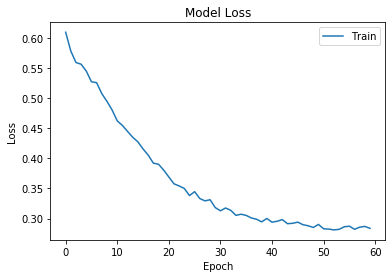

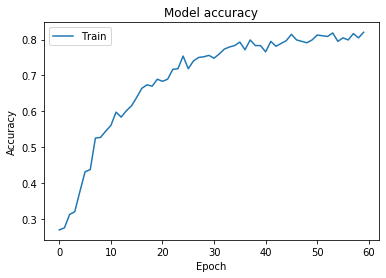

In [4]:
# output = classifier.predict_generator(test_set, steps=1)
# print(test_set.class_indices)
# print(output)
size = y_test[:,-1]
print(size.size)


# predict 10 random hand-writing data
y_predicted = model.predict(x_test)
for x in range(0,size.size):
    
    print("index:", x,
          " actual y:", np.argmax(y_test[x]),
          " answer y:", np.argmax(y_predicted[x]),
            " prediction:", np.array(y_predicted[x]))

evaluation = model.evaluate(x_test, y_test)
print('loss: ', evaluation[0])
print('accuracy', evaluation[1])

import matplotlib.pyplot as plt

# 손실 그래프
def plot_loss(history):
   # 선 그리기
   plt.plot(history.history['loss'])
   # 그래프 제목
   plt.title('Model Loss')
   # x,y축 이름 표시
   plt.ylabel('Loss')
   plt.xlabel('Epoch')
   # 각 라인 표식 표시
   plt.legend(['Train','Test'],loc=0)

# 정확도 그래프
def plot_acc(history):
  # dir(history.history)
   plt.plot(history.history['accuracy'])
   plt.title('Model accuracy')
   plt.ylabel('Accuracy')
   plt.xlabel('Epoch')
   plt.legend(['Train', 'Test'], loc=0)

plot_loss(history)
plt.show()
plot_acc(history)
plt.show()

In [5]:
# batch_size = [128,256,512,1024]
# learning_rate = [0.00001,0.0001,0.001]
# for  batch_size, learning_rate in product(batch_size,learning_rate):
#     print(f'batchSIZE is {batch_size}, Learning Rate is {learning_rate}')
#     train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)

#     test_datagen = ImageDataGenerator(rescale = 1./255)

#     categories = ['dog','cat','rabbit','squirrel']

#     training_set = train_datagen.flow_from_directory(train_img_dir, target_size=(128,128), 
#                                                  classes=categories, 
#                                                  batch_size=batch_size)

#     test_set = test_datagen.flow_from_directory(test_img_dir,
#                                             target_size=(128,128), 
#                                             classes=categories, 
#                                             batch_size=batch_size)



#     x_train, y_train = next(training_set)
#     x_test, y_test = next(test_set)
#     model = create_model()
#     ## learning rate scheduing
#     lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
#                                                               decay_steps=training_epochs*10,
#                                                               decay_rate=0.4,
#                                                               staircase=True)
#     ## optimizer는 Adam, loss는 sparse categorical crossentropy 사용
#     ## label이 ont-hot으로 encoding 안 된 경우에 sparse categorical corssentropy 및 sparse categorical accuracy 사용
#     model.compile(keras.optimizers.Adam(lr_schedule), loss = 'binary_crossentropy', metrics = ['accuracy'])

#     ## Train!
#     model.fit(x_train, y_train, steps_per_epoch=training_epochs,
#              epochs=12)
#     # output = classifier.predict_generator(test_set, steps=1)
#     # print(test_set.class_indices)
#     # print(output)
#     size = y_test[:,-1]
#     print(size.size)


#     # predict 10 random hand-writing data
#     y_predicted = model.predict(x_test)
#     for x in range(0,size.size):

#         print("index:", x,
#               " actual y:", np.argmax(y_test[x]),
#               " answer y:", np.argmax(y_predicted[x]),
#                 " prediction:", np.array(y_predicted[x]))

#     evaluation = model.evaluate(x_test, y_test)
#     print('loss: ', evaluation[0])
#     print('accuracy', evaluation[1])

